# notes on classification (sklearn)

References cited throughout the text:

* `sklearn` documentation (http://scikit-learn.org/stable/tutorial/basic/tutorial.html)
* QSI: Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005)

Other links:

* machine learning, splitting data in train and test dataset with sklearn, linear regression etc:<https://www.dataquest.io/blog/getting-started-with-machine-learning-python/>
* good explanation on knn: <http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_ml/py_knn/py_knn_understanding/py_knn_understanding.html>
* http://scikit-learn.org/stable/tutorial/basic/tutorial.html
* https://github.com/amueller/scipy_2015_sklearn_tutorial/tree/master/notebooks
* http://www.r2d3.us/visual-intro-to-machine-learning-part-1/




### supervised vs unsupervised learning


_Supervised learning_ consists in learning the link between two datasets: the observed data X and an external variable y (usually called _target_) that we are trying to predict.

If the prediction task is to classify the observations in a set of labels, in other words to "name" the objects observed, the task is said to be a _classification_ task. On the other hand, if the goal is to predict a continuous target variable, it is said to be a _regression_ task.

_Unsupervised learning_ consists in discovering more information in observed, unlabeled, data (i.e., without any corresponding target). Discovering "more" means to either finding groups with similar characteristics within the data (_clustering_), or to determine the distribution of data within the input space (_density estimation_).


### [qsi chapter 3]

>random variables: we use them to model uncertainty mathematically; continuous variables (porosity) vs categorical variables (shale/sand lithology).

>pdf are the shapes that fully describe the uncertain quantity (e.g., porosity); to estimate pdf from observed data, we either use a parametric approach (i.e. assume that pdf is a known function e.g. Gaussian, and estimate its parameters e.g. mean and variance from observed data) or a nonparametric approach (the simplest non-parametric pdf estimate is histogram; also kernel estimators etc).

>pdf-based classification may be hard computationally or just not reliable because of sparse data when more than 3-4 attributes are used; in this case classification methods such as KNN or neural networks have to be used.

> statistical classification: when inputs and outputs are quantitative variables we call the problem a regression problem; then the outputs are categorical then we call is classification problem.

> first method: discriminant analysis, uses only mean and covariance of training data (underlying assumption is that data has Gaussian distribution). The new unknown samples are classified according to minimum Mahalanobis distance (=Euclidean distance scaled by covariance) to each cluster of the training data.

[bayesian classification, 3.6.2]

> to upscale the log-derived crossplots and pdf to seismic scale... is tosmooth the well log data at lambda/4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

from matplotlib.colors import ListedColormap
colr1=['mediumblue', 'darksage', 'darkred']
colr2=['royalblue', 'sage', 'indianred']
cmap1 = ListedColormap(colr1)
cmap2 = ListedColormap(colr2)

I will now load Ip and Vp/Vs logs from well 2, in the interval 2100 to 2300 meters; I will select only those datapoints that belong to the following 3 facies:

* LFC 1 = brine sand
* LFC 2 = oil sand
* LFC 4 = shales

The datapoints will be stored in two arrays:

* `data` (N samples x 2 "features" as they're called in machine learning, i.e. Ip and Vp/Vs)
* `target` (N samples containing the class ID for each sample)

(<matplotlib.legend.Legend at 0xc54efd0>, None)

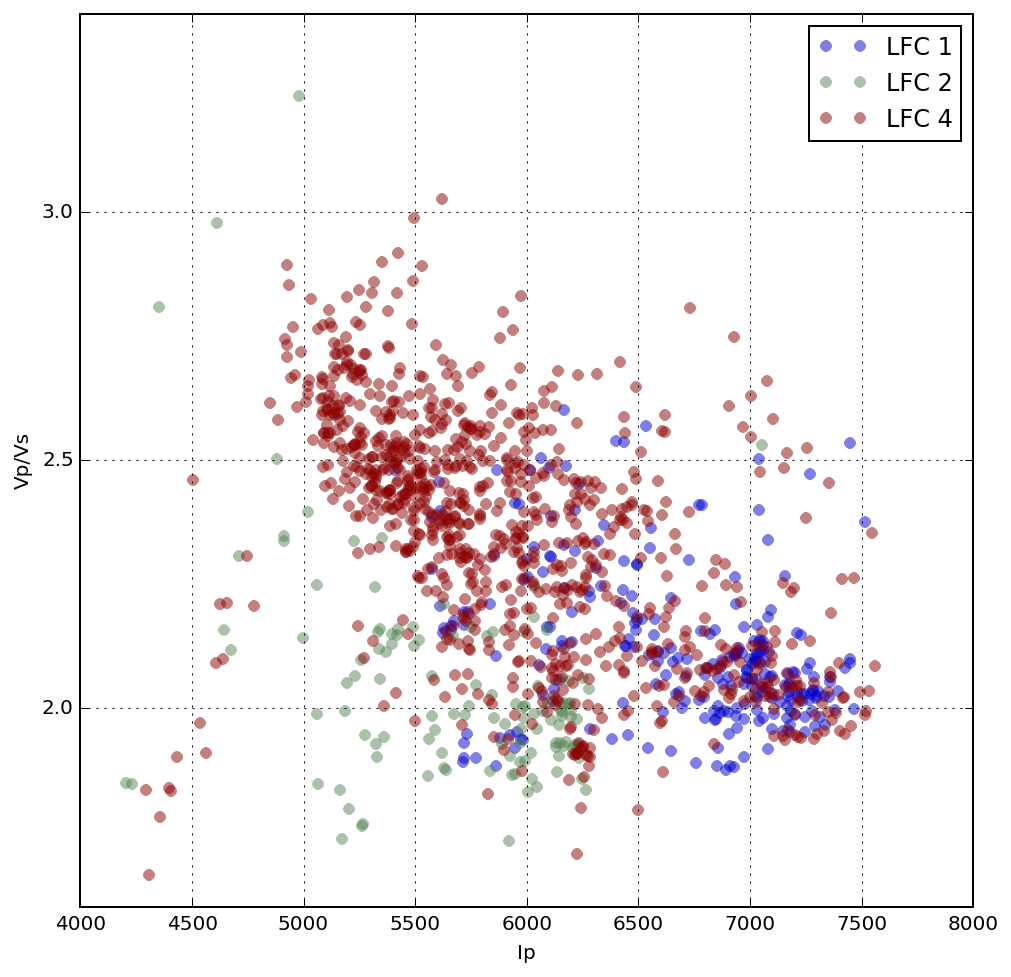

In [2]:
w2=pd.read_csv('qsiwell2_frm.csv')

facies2=(w2.DEPTH>=2100) & (w2.DEPTH<=2300) & ((w2.LFC==1)|(w2.LFC==2))
facies3=(w2.DEPTH>=2100) & (w2.DEPTH<=2300) & ((w2.LFC==1)|(w2.LFC==2)|(w2.LFC==4))

data    = w2[facies3][['IP','VPVS']].values
target  = w2[facies3]['LFC'].values

plt.figure(figsize=(8,8))
for i,val in enumerate(np.unique(target)):
    idx = (target == val)
    plt.plot(data[idx,0], data[idx,1], 'o', mew=0, c=colr1[i], alpha=0.5, label='LFC {:.0f}'.format(val))
plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
plt.legend(), plt.grid()

### preprocessing

When you set out to do a machine learning process you _may_ have to do these things:

* change the range of values of the observed data (rescaling, normalizing, standardizing)
* split the observed data into training and test datasets

Actually I stand corrected, the second point is pretty much compulsory to judge the robustness of the classification process (from what I understand).

The first point, I'm not sure; in my experience, when working with elastic properties like acoustic impedance and Vp/Vs ratio that cover vastly different range of values (5000-20000 for the first and 1-3 for the second) I have found that I _had_ to do that to make the classifier work.

See also:
* http://scikit-learn.org/stable/modules/preprocessing.html
* http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html
* rescaling related to classifying geophysical stuff, see QSI p.130

_Rescaling_ data means to add or subtract a constant and then multiply or divide by a constant.

_Normalizing_ data often means scaling individual samples to have unit norm , or rescaling to make all the samples lie between 0 and 1. 

_Standardizing_ a vector most often means subtracting a measure of location and dividing by a measure of scale. For example, if the data contains random values with a Gaussian distribution, you might subtract the mean and divide by the standard deviation, thereby obtaining a "standard normal" random variable with mean 0 and standard deviation 1.

From what I understand, the normal approach is standardization (which you do in sklearn using `StandardScaler`); to rescale the  features to lie between a given minimum and maximum value, often between zero and one, `MinMaxScaler` can be used.
If data is sparse: `MaxAbsScaler`, if it has outliers: `RobustScaler`.
Normalization (`normalize`) is probably not the one I should bother when dealing with geophysical attributes.

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, normalize
X=StandardScaler().fit_transform(data)
X1=MinMaxScaler().fit_transform(data)
X2=RobustScaler().fit_transform(data)
X3=normalize(data,axis=0)

The following plot shows the difference between original (_black_) and reprocessed data (_red_) through their histograms. Check the scales on the x-axis to understand the effect of the various standardization/rescaling/normalization algorithms.

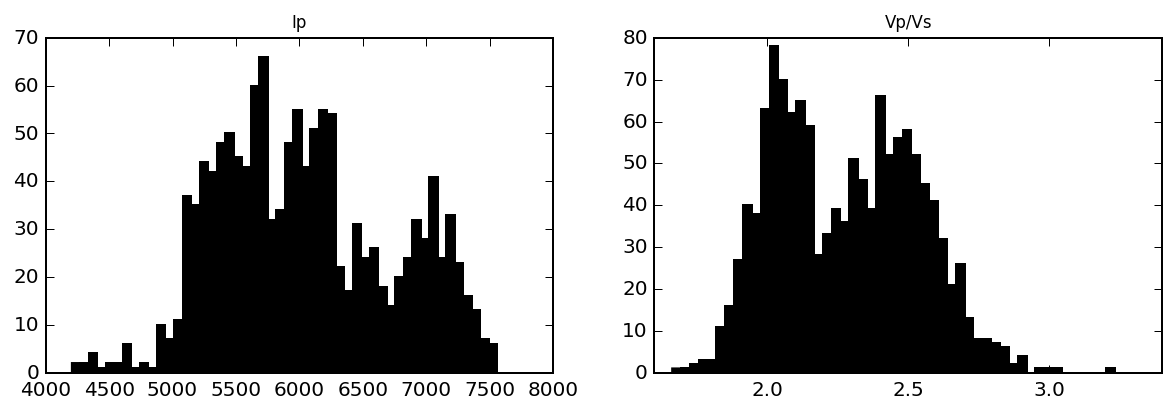

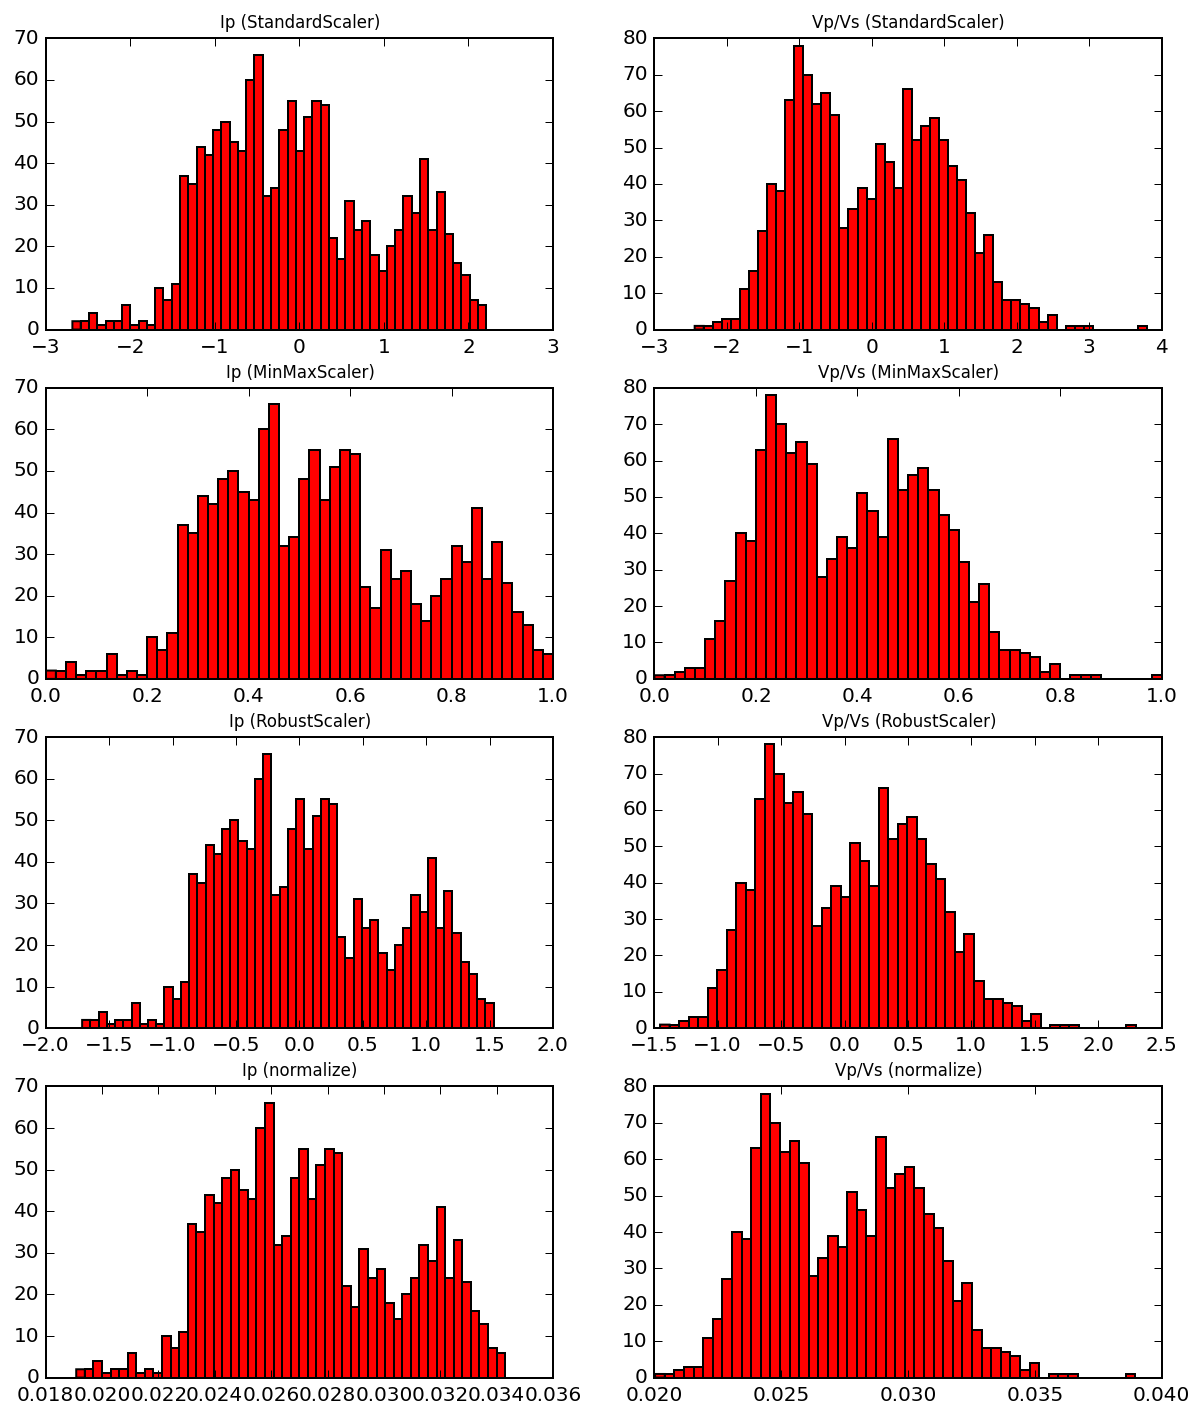

In [5]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax[0].hist(data[:,0],bins=50,color='k')
ax[1].hist(data[:,1],bins=50,color='k')
ax[0].set_title('Ip', fontsize='smaller'), ax[1].set_title('Vp/Vs', fontsize='smaller') 

metodi=['StandardScaler','MinMaxScaler','RobustScaler','normalize']
nsamples=100
f, ax = plt.subplots(nrows=4, ncols=2,figsize=(10,12))
for i,val in enumerate([X,X1,X2,X3]):
    ax[i,0].hist(val[:,0],bins=50,color='r')
    ax[i,1].hist(val[:,1],bins=50,color='r')
    ax[i,0].set_title('Ip ({0})'.format(metodi[i]), fontsize='smaller')
    ax[i,1].set_title('Vp/Vs ({0})'.format(metodi[i]), fontsize='smaller')

Remember that from now on we have copied Ip and Vp/Vs into the `data` array, then we have standardized it (using `sklearn.preprocessing.StandardScaler`) and stored into the `X` numpy array.

The next step is to split the entire data (`X` and `target`) into two part, one will be used to train the algorithm (`X_train` and `y_train`) and one to test the results (`X_test` and `y_test`). The training dataset is usually larger than the test dataset.

training data size: 1968 samples = 0.75%
test data size: 656 samples = 0.25%


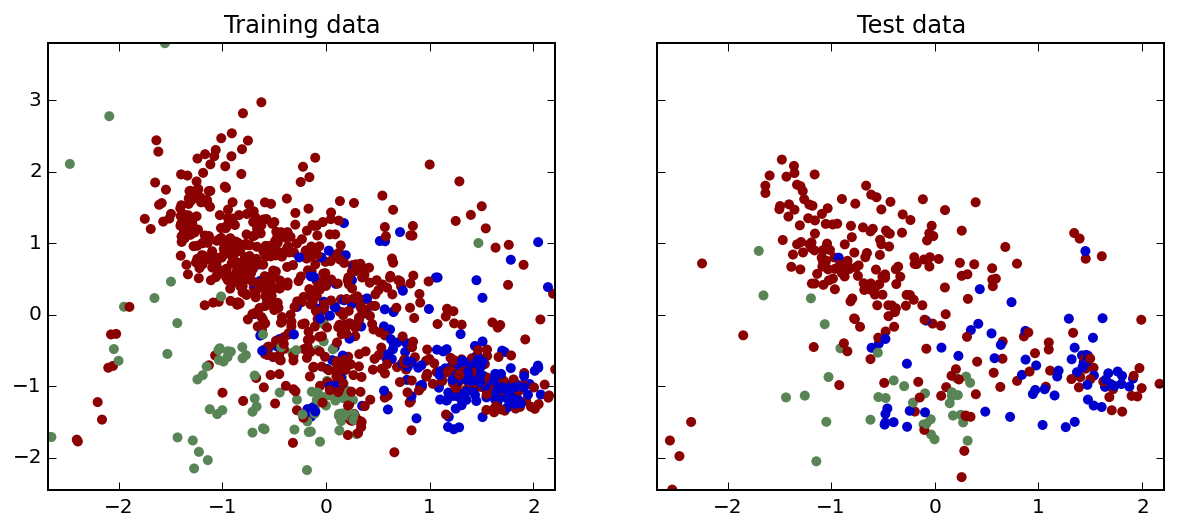

In [21]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target) # default test size = 0.25

print 'training data size: {0} samples = {1}%'.format(X_train.size,np.float(X_train.size)/X.size)
print 'test data size: {0} samples = {1}%'.format(X_test.size,np.float(X_test.size)/X.size)

xmin,ymin = X.min(axis=0)
xmax,ymax = X.max(axis=0)

f, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,4), sharex=True, sharey=True)
ax[0].scatter(X_train[:,0],X_train[:,1],25,c=y_train,cmap=cmap1,edgecolor='none',marker='o')
ax[1].scatter(X_test[:,0],X_test[:,1],25,c=y_test,cmap=cmap1,edgecolor='none',marker='o')
plt.axis([xmin,xmax,ymin,ymax])
ax[0].set_title('Training data')
ax[1].set_title('Test data')

## Linear and Quadratic Discriminant Analysis

Linear (and quadratic) discriminant analysis are among the simplest classifiers, but they are also very robust (see section 3.6.1, p.140 in QSI and

I was trying to write a brief summary of these but then I got stuck because you see, QSI (p.140) introduces LDA in a few words and then gets right to the equation for the Mahalanobis distance:

$$ M = ( x- \mu_i)^T \Sigma^{-1} (x - \mu_i) $$

the point being that samples are classified according to the minimum Mahalanobis distance to each cluster in the training data. Ok I get that, it is so simple that I have always intuitively understood this algorithm. Yes, they also say that you need to calcualte means and covariances of the training data and assume they follow a Gaussian distribution.

But looking at the [sklearn docs](http://scikit-learn.org/stable/modules/lda_qda.html) and the [wikipedia page on LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) I then discovered that the method is rooted in the usual probabilistic Bayesian theory, i.e.

$$ P(y=k \mid X) = \frac{P(X \mid y=k) \, P(y=k)}{P(X)} $$

That is, the probability of y classified as class k given X is equal to...

http://ocw.mit.edu/courses/sloan-school-of-management/15-062-data-mining-spring-2003/lecture-notes/lecture4.pdf

http://people.revoledu.com/kardi/tutorial/LDA/LDA.html#LDA


In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classf = LinearDiscriminantAnalysis(solver='svd', store_covariance=True).fit(X_train, y_train)
predictions=classf.predict(X_test)

To check the results of the classification, we can plot side by side the test dataset with true and predicted labels (on the left plot the colors represent the predicted labels, and I have highlighted the samples where the predictions are wrong with black circles):

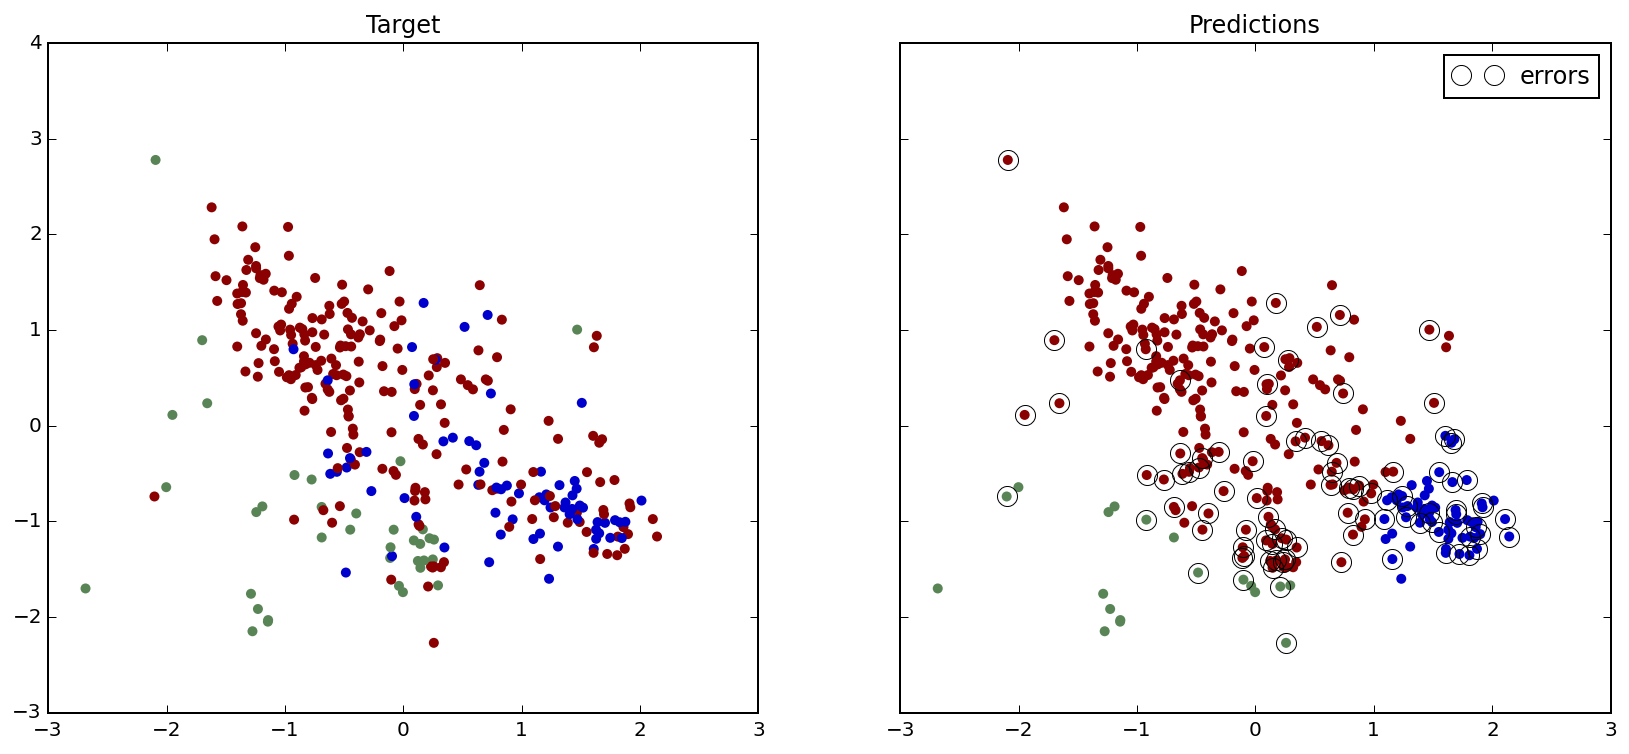

In [68]:
errors=~(predictions==y_test)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharex=True, sharey=True)
ax[0].scatter(X_test[:,0],X_test[:,1],25,c=y_test,cmap=cmap1,edgecolor='none',marker='o')
ax[0].set_title('Target')
ax[1].scatter(X_test[:,0],X_test[:,1],25,c=predictions,cmap=cmap1,edgecolor='none',marker='o')
ax[1].plot(X_test[errors,0],X_test[errors,1],'o',mec='k',ms=10,fillstyle='none', label='errors')
ax[1].set_title('Predictions')
ax[1].legend()

A simple quantitative estimation of the results is stored in the `score` method of the classifierm which gives the average number of hits, i.e. the number of samples where the prediction is correct:

In [66]:
print 'score = {0}'.format(classf.score(X_test, y_test))

score = 0.704268292683


This is the same as (in straight Numpy):

In [67]:
print np.mean(classf.predict(X_test) == y_test)

0.704268292683


There are many other ways to assess the classification outcomes, such as the mean squared error (MSE) etc. `sklearn` can also output a table with the following parameters:

* precision: ability of the classifier not to label as positive a sample that is negative
* recall: ability of the classifier to find all the positive samples
* f1: weighted harmonic mean of the precision and recall (best value at 1 and its worst score at 0)

See the following links for more details:
* https://github.com/astroML/sklearn_tutorial/blob/master/doc/notebooks/07_classification_example.ipynb
* http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

In [76]:
from sklearn.metrics import mean_squared_error, classification_report

print 'MSE = {0}'.format(mean_squared_error(predictions, y_test)) # forse non e' significativo per classificatori multiclass ma solo per regression?

target_names = ['class 1', 'class 2', 'class 4']
print(classification_report(target, y_pred, target_names=target_names))

MSE = 2.19512195122
             precision    recall  f1-score   support

    class 1       0.59      0.53      0.56       262
    class 2       0.57      0.35      0.43       123
    class 4       0.81      0.87      0.83       927

avg / total       0.74      0.75      0.74      1312



Another very well known method is the _confusion_ (or _contingency_) matrix, that will give for each class how many samples have been correctly predicted or not (e.g., the number of samples of class 1 that have been identified as class 2 or 4).

This table can be printed as text:

In [80]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(predictions, y_test)
print confmat

[[ 31   0  29]
 [  1  13   5]
 [ 38  24 187]]


In the following code I will print out the confusion matrix line by line; each line will contain the total number of samples for each class, and for every cell within the line the numbers will indicate how many samples have been predicted as belonging to the first, second or third class.

For this particular example, the first line (facies 1, brine sand) reports 31 samples predicted as class 1 (correct prediction), 0 as class 2 and 29 samples as class 4 (wrong prediction); the second line (second class, i.e. facies 2 / oil sand) reports 1 sample predicted as class 1 (wrong), 13 as class 2 (correct) and 5 as class 4 (wrong); the third line (third class, i.e. facies 4 / shales) reports 38 samples as class 1 (wrong), 24 as class 2 (wrong) and 187 out of 249 total samples correctly predicted.

In [81]:
for i,val in enumerate(classf.classes_):
    print '{0} --> total samples for class {1} = {2}'.format(confmat[i,:], val, predictions[predictions==val].size)

[31  0 29] --> total samples for class 1.0 = 60
[ 1 13  5] --> total samples for class 2.0 = 19
[ 38  24 187] --> total samples for class 4.0 = 249


A good way to understand the matrix is to plot it out graphically and label it properly:

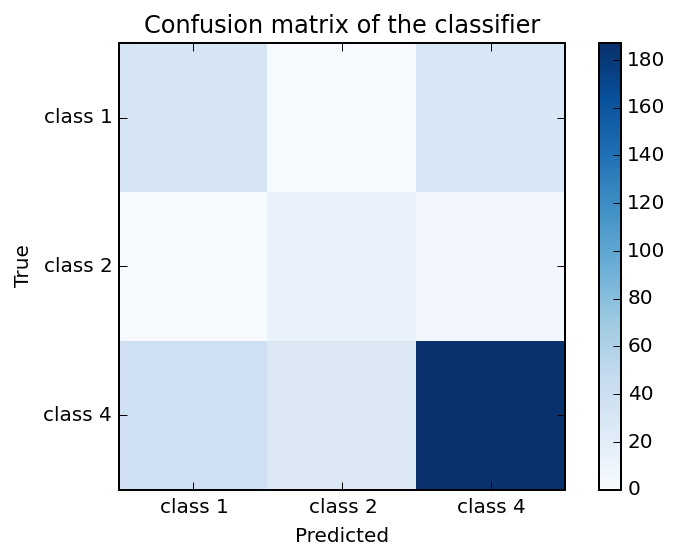

In [79]:
plt.figure()
plt.imshow(confmat, cmap='Blues', interpolation='None')
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(classf.classes_.size),target_names)
plt.yticks(np.arange(classf.classes_.size),target_names)
plt.xlabel('Predicted')
plt.ylabel('True')

A better way to show the results of a classification is to show the space where my data lives separated into differently colored portions; each portion will be the subspace where data will be classified as belonging to a particular class.

First, I create a grid over the standardized elastic properties space:

In [16]:
nsamples=100
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min,x_max,nsamples),np.linspace(y_min,y_max,nsamples))

Now I will use this grid (`xx`, `yy`) to create a display that will show very clearly the results of a classifier; it is especially useful when comparing different classifiers so I will now compare LDA with QDA (_quadratic discriminant analysis_) to classify the same data.

To create this display I apply the classification to the entire space defined by `xx` and `yy`, store the results into an array that is then reshaped with the same geometry used to create `xx` and `yy` before (i.e., a 100x100 grid). I will have two of these arrays, `Zlda` and `Zqda` that can be showed as images (`pcolormesh`) side by side:

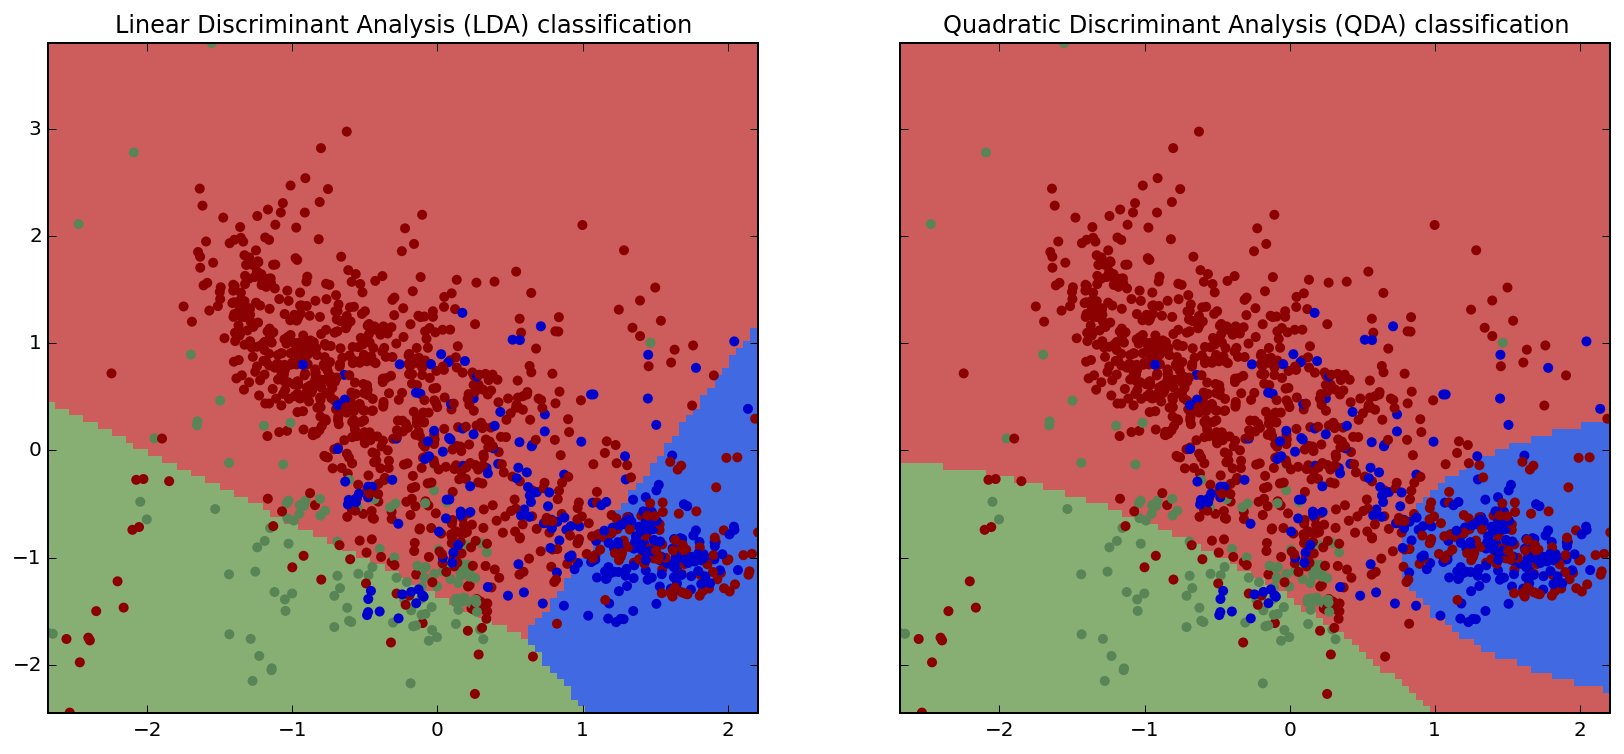

In [37]:
lda = LinearDiscriminantAnalysis(solver='svd', store_covariance=True).fit(X, target)
Zlda = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

qda = QuadraticDiscriminantAnalysis(store_covariances=True).fit(X, target)
Zqda = qda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

f, ax = plt.subplots(nrows=1, ncols=2,figsize=(14,6), sharex=True, sharey=True)
ax[0].pcolormesh(xx, yy, Zlda, cmap=cmap2)
ax[0].scatter(X[:,0],X[:,1],25,c=target,cmap=cmap1,edgecolor='none',marker='o')
ax[0].set_title('Linear Discriminant Analysis (LDA) classification')
ax[1].pcolormesh(xx, yy, Zqda, cmap=cmap2)
ax[1].scatter(X[:,0],X[:,1],25,c=target,cmap=cmap1,edgecolor='none',marker='o')
ax[1].set_title('Quadratic Discriminant Analysis (QDA) classification')
_=ax[0].axis([x_min,x_max,y_min,y_max])